# TP3
### Équipe 10
### Fabrice Charbonneau (1798064)
### Sanou Armel Kenzanga Landry (1976804)


1. créer une matrice termes-documents; pour diminuer la taille du vocabulaire, utiliser un stemmer et éliminer les chiffres et la ponctuation;
2. transformer les fréquences brutes par les valeurs TF-IDF;
3. effectuer une réduction de dimensions avec SVD; utilisez 50 dimensions latentes.



D'abord, lire les fichiers et les ajouter à un dataframe.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nltk.corpus import PlaintextCorpusReader
from os import path

#can be removed
from jupyterthemes import jtplot
jtplot.style()

In [2]:
if not path.exists("raw_data.csv"):
    i = 0
    df = pd.DataFrame(columns=['uni', 'course', 'text'])
    class_data = 'Descriptions' 
    corpus = PlaintextCorpusReader(class_data, '.*txt', encoding='latin-1')
    for file in corpus.fileids():
        uni_str = file.split("/")[0]
        new_corpus = PlaintextCorpusReader(class_data, file, encoding='latin-1')
        df.loc[i] = [uni_str, file.split("/")[1].split(".")[0], new_corpus.raw()]
        i += 1
        print(i,  end='\r')
    df.to_csv("raw_data.csv", index=False)

In [3]:
df = pd.read_csv("raw_data.csv")

Détection du langage des textes avec https://pypi.org/project/langdetect/

Nous n'allons conserver que les cours ayant comme langage détecté le français.

In [4]:
from langdetect import detect

if not path.exists("fr_only.csv"):
    df["lang"] = df.apply( lambda row: detect(row["text"]), axis=1)
    df = df[df["lang"] == "fr"]
    df.to_csv("fr_only.csv", index=False)
df = pd.read_csv("fr_only.csv")

In [5]:
df = df.drop(columns="lang")

In [6]:
df

,Unnamed: 0,uni,course,text
0,0,HEC,1-404-96,TitreCours: Sociologie de l\nDescriptionCours:...
1,1,HEC,1-407-00,TitreCours: Management\nDescriptionCours: Ce c...
2,3,HEC,1-611-09,TitreCours: Modelisation et optimisation\nDesc...
3,4,HEC,1-611-96,TitreCours: Modelisation et optimisation\nDesc...
4,5,HEC,1-612-96,TitreCours: Mathematiques financieres\nDescrip...
...,...,...,...,...
16050,16330,UdM,VNM1060H,TitreCours: Vietnamien elementaire 2\nDescript...
16051,16331,UdM,VNM2050,TitreCours: Vietnamien intermediaire 1\nDescri...
16052,16332,UdM,VNM2050H,TitreCours: Vietnamien intermediaire 1\nDescri...
16053,16333,UdM,VNM2060,TitreCours: Vietnamien intermediaire 2\nDescri...


Utilisation d'un Tokenizer pour séparer les strings en mots.

TweetTokenizer de nltk est à la base fait pour les tweets, donc traite le texte pouvant contenir des hashtags et autres particularité des tweets. Dans notre cas, ça ne change pas grand chose, il fera facilement le travail même le texte n'est pas des tweets.

In [7]:
from nltk.tokenize import TweetTokenizer
tknzr = TweetTokenizer()
tokens = df["text"].apply(lambda x: tknzr.tokenize(x)).values

Stemmer afin d'éliminer les tokens inutles

In [8]:
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.corpus import stopwords

In [9]:
st = SnowballStemmer("french", ignore_stopwords=True)
[st.stem(word) for word in ["Yeux", "Sociologie", ".", "souris"]]

['yeux', 'sociolog', '.', 'sour']

In [10]:
class Preprocessor:
    def __init__(self, stem=True, punctuation=True, digit=True):
        self.st = SnowballStemmer("french", ignore_stopwords=True)
        self.punctuations = set(string.punctuation)
        self.stem = stem
        self.punctuation = punctuation
        self.digit = digit
    
    def raw_preprocess(self, token_list):
        new_token_list = []
        for token in token_list:
            is_token_valid = True
            token = token.lower()
            
            # stemming
            if self.stem:
                token = self.st.stem(token)

            # punctuation filtering
            if self.punctuation and token in self.punctuations:
                is_token_valid = False

            # digit filtering
            elif self.digit and token.isdigit():
                is_token_valid = False

            # add token to new sub list
            if is_token_valid:
                new_token_list.append(token)
        return new_token_list
        
    def preprocess_tokens(self, tokens):
        new_tokens = []
        for token_list in tokens:
            new_tokens.append(self.raw_preprocess(token_list))
        return new_tokens
    
def preprocess(tokens):
    preprocessor = Preprocessor()
    return preprocessor.preprocess_tokens(test)

In [11]:
test = [
    ['Sociologie', 'de', 'l', 'DescriptionCours', ':', 'Trois', 'volets', 'principaux', 'dans', 'ce', 'cours'],
    ['Management', 'DescriptionCours', ':', 'Ce', 'cours', 'est', 'une', 'introduction', 'au', 'management', 'et']
]
preprocessor = Preprocessor()
preproc_test = preprocessor.preprocess_tokens(test)
preproc_test

[['sociolog',
  'de',
  'l',
  'descriptioncour',
  'trois',
  'volet',
  'principal',
  'dans',
  'ce',
  'cour'],
 ['manag',
  'descriptioncour',
  'ce',
  'cour',
  'est',
  'une',
  'introduct',
  'au',
  'manag',
  'et']]

TF-IDF

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer

def identity_tokenizer(text):
    return text

vectorizer = TfidfVectorizer(preprocessor=preprocessor.raw_preprocess ,tokenizer=identity_tokenizer)
#vectorizer = TfidfVectorizer(preprocessor=preprocessor.raw_preprocess)
IDF_data = vectorizer.fit_transform(tokens)

In [13]:
IDF_data

<16055x21286 sparse matrix of type '<class 'numpy.float64'>'
	with 713904 stored elements in Compressed Sparse Row format>

SVD

In [14]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, algorithm='randomized', n_iter=100)
svd.fit(IDF_data)

TruncatedSVD(algorithm='randomized', n_components=50, n_iter=100,
             random_state=None, tol=0.0)

In [15]:
sum(svd.explained_variance_)

0.18373293516944866

In [16]:
SVD_data = svd.transform(IDF_data)

## 1. Quels sont les 10 cours les plus similaires à LOG2420 dans l'espace réduit à 50 dimensions? (8 pts.) Prenez le cosinus comme mesure de similarité. 

In [17]:
LOG2420_idx = df.index[df["course"] == 'LOG2420'][0]

In [18]:
from sklearn.metrics.pairwise import cosine_similarity
cos_matrix = cosine_similarity(SVD_data)

In [19]:
log_2420_cos = cos_matrix[LOG2420_idx]
log_2420_sorted_cos = np.sort(log_2420_cos)
recommendations_cos = log_2420_sorted_cos[::-1][1:11] #[::-1] reverses the list, and [1:11] takes the 10 firsts ignoring the very first one which is the course itself

In [20]:
recommendations_indexes = [np.where(log_2420_cos == reco)[0][0] for reco in recommendations_cos]

In [21]:
df.loc[list(recommendations_indexes)]

,Unnamed: 0,uni,course,text
1669,1888,Poly,LOG1000,TitreCours: Ingenierie logicielle\nDescription...
1585,1804,Poly,INF1005C,TitreCours: Programmation procedurale\nDescrip...
1584,1803,Poly,INF1005B,TitreCours: Programmation procedurale\nDescrip...
1583,1802,Poly,INF1005A,TitreCours: Programmation procedurale\nDescrip...
1660,1879,Poly,INF8701,TitreCours: Simulation des systemes a evenem. ...
967,1186,Poly,AE4500,TitreCours: Informatique embarque\nDescription...
1670,1889,Poly,LOG2410,TitreCours: Conception logicielle\nDescription...
1682,1901,Poly,LOG4430,TitreCours: Architecture logicielle et concept...
1552,1771,Poly,IND6402,TitreCours: Interfaces humains-ordinateurs\nDe...
1658,1877,Poly,INF8500,TitreCours: Systemes embarques:conception et v...


## 2. Effectuez une classification de cours par une approche supervisée (4 pts.) Pour établir les libellés de classes, prenez les acronymes de cours commençant par PSY (psychologie) et PHY (physique). Calculez les centroides de chaque classe (PSY et PHY) des données d'entraînement et calculez l'aire sous la courbe ROC pour la prédiction de données de test (AUC, Area Under receiver operator Curve). 

In [22]:
mask = ((df["course"].astype(str).str[:3] == "PSY") | (df["course"].astype(str).str[:3] == "PHY"))
class_df = df[mask]

class_df["PSY"] = df["course"].astype(str).str[:3] == "PSY"
class_df

/home/fabrice/.local/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,Unnamed: 0,uni,course,text,PSY
7633,7891,UQAM,PHY0350,TitreCours: Introduction a la mecanique genera...,False
7634,7892,UQAM,PHY1011,TitreCours: L\nDescriptionCours: Ce cours s'ad...,False
7635,7893,UQAM,PHY1020,TitreCours: Les systemes physiques\nDescriptio...,False
7636,7894,UQAM,PHY1030,TitreCours: La physique des interactions et de...,False
7637,7895,UQAM,PHY1050,TitreCours: Mecanique\nDescriptionCours: Ce co...,False
...,...,...,...,...,...
15102,15379,UdM,PSY3299,TitreCours: Stage d'initiation a la psychologi...,True
15103,15380,UdM,PSY3952,TitreCours: Psychologie en readaptation\nDescr...,True
15104,15381,UdM,PSY3954,TitreCours: Methodes d'entrevue en sante\nDesc...,True
15105,15382,UdM,PSY4000,TitreCours: Projet de recherche Honor\nDescrip...,True


In [23]:
PHY_PSY_indexes = list(class_df.index.values)

In [24]:
def retrieve_PHY_PSY(full_data):
    PHY_PSY_data = []
    for index in PHY_PSY_indexes:
        PHY_PSY_data.append(full_data[index])
    return  np.array(PHY_PSY_data)

In [25]:
X_data = retrieve_PHY_PSY(SVD_data)

In [26]:
y_data = class_df["PSY"].values

In [27]:
len(X_data)

521

In [28]:
len(y_data)

521

In [29]:
n_positives = 0
for y in y_data:
    if y:
        n_positives += 1
n_positives

407

In [30]:
# proportion de cours de psychologie
n_positives/len(y_data)

0.781190019193858

tiré de https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci/52910821

In [31]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.4, random_state=42)

In [32]:
print(len(X_train))
print(len(X_test))

312
209


In [33]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=20)
knn_classifier.fit(X_train, y_train)

y_scores = knn_classifier.predict_proba(X_test)

In [34]:
y_scores[:10]

array([[0.05, 0.95],
       [0.05, 0.95],
       [1.  , 0.  ],
       [0.  , 1.  ],
       [0.  , 1.  ],
       [0.3 , 0.7 ],
       [0.35, 0.65],
       [0.1 , 0.9 ],
       [0.05, 0.95],
       [0.4 , 0.6 ]])

In [35]:
y_test[:10]

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
        True])

On peut déjà voir que le modèle semble bien identifier les cours.

In [36]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

false_positive_rate, true_positive_rate, threshold = roc_curve(y_test, y_scores[:, 1])
roc_auc = auc(false_positive_rate, true_positive_rate)

In [37]:
def plot_ROC_AUC(FP_rate, TP_rate, AUC):
    plt.plot(FP_rate, TP_rate, 'g', label = 'AUC = %0.3f' % AUC)
    plt.legend()
    plt.plot([0, 1], [0, 1], 'y--')
    plt.xlim([-0.1, 1])
    plt.ylim([0, 1.1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.title('ROC Curve')
    plt.show()

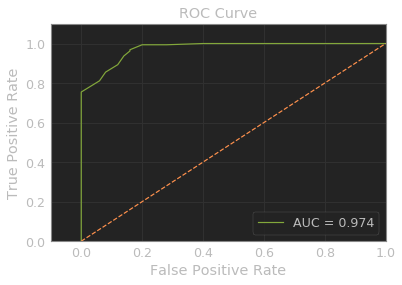

In [38]:
plot_ROC_AUC(false_positive_rate, true_positive_rate, roc_auc)

##  3. Effectuez une agglomération par k-means (k=2) et vérifiez si les classes PHY et PSY sont bien séparées par cette méthode (4 pts.).

2019.11.15. n.b. les questions 3 et 4 sont inversées par rapport à la version précédente.
Une approche non supervisée est adoptée ici, car nous n'utiliserons pas les "classes" PHY et PSY pour l'entraînement mais seulement pour le test.

Utilisez kmeans avec deux classes pour agglomérer les 521 cours PSY et PHY. Vérifiez si la classification correspond dans une bonne mesure aux deux ensembles de cours. Calculez la précision, le score F1 et finalement l'AUC avec la même méthode qu'à la question 2.

À noter qu'à cette étape, la classification donnée par le Knn peut être inattendue, mais l'AUC devrait être aux alentours de 0,75.


In [42]:
from sklearn.cluster import KMeans
# deterministic
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_data)
#kmeans = KMeans(n_clusters=2).fit(X_data)
labels = kmeans.labels_
sum(labels)

474

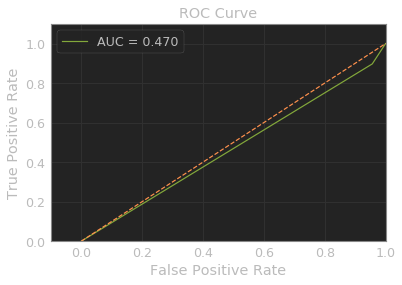

In [43]:
false_positive_rate, true_positive_rate, threshold = roc_curve(y_data, labels)
roc_auc = auc(false_positive_rate, true_positive_rate)
plot_ROC_AUC(false_positive_rate, true_positive_rate, roc_auc)

Puisque les labels ne contiennent que 2 valeurs possibles, soit 0 et 1, il n'est pas possible d'obtenir une belle courbe ROC avec plus de 3 points. C'est pourquoi nous allons plutôt utiliser une probabilité au cluster attribué en calculant la distance entre les points et les centres finaux.

In [46]:
def distance(center, point):
    return np.linalg.norm(center-point)

# This returns a score between 0 and 0.5 because we know the distance between the point's cluster and the cluster's center is less than the distance with the other cluster's center (by the nature of kmeans)
def score_proba(center, other_center, point):
    within_dist = distance(center, point)
    total_distances = within_dist + distance(other_center, point)
    return within_dist / total_distances

In [47]:
def labels_to_probas(centers, labels, points):
    probas = []
    for i in range(len(points)):
        point = points[i]
        label = labels[i]
        center = centers[label]
        other_center = centers[0]
        if label == 0:
            other_center = centers[1]
        proba = score_proba(center, other_center, point)
        if label == 1:
            proba = 1 - proba
        probas.append(proba)
    return probas

In [48]:
centers = kmeans.cluster_centers_
probas = labels_to_probas(centers, labels, X_data)

In [49]:
def reverse_predictions(predictions):
    new_predictions = []
    for pred in predictions:
        new_predictions.append(1 - pred)
    return new_predictions

In [50]:
def roc_curve_wrapper(actual, predictions):
    false_positive_rate, true_positive_rate, threshold = roc_curve(actual, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    # if AUC is less than 0.5 just reverse all predictions
    if roc_auc < 0.5:
        predictions = reverse_predictions(predictions)
        false_positive_rate, true_positive_rate, threshold = roc_curve(actual, predictions)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
    plot_ROC_AUC(false_positive_rate, true_positive_rate, roc_auc)    

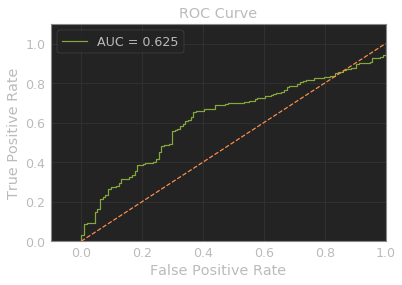

In [51]:
roc_curve_wrapper(y_data, probas)

Afin d'améliorer davantage les résultats, nous allons commencer le processing directement sur uniquement les cours PHY et PSY (TF-IDF et SVD) afin de réduire les dimensions à uniquement ce que comprend les descriptions de ces cours et non l'ensemble de tous les cours.

In [52]:
PHY_PSY_tokens = retrieve_PHY_PSY(tokens)

In [53]:
PHY_PSY_TFIDF = vectorizer.fit_transform(PHY_PSY_tokens)

In [54]:
PHY_PSY_TFIDF

<521x3176 sparse matrix of type '<class 'numpy.float64'>'
	with 22166 stored elements in Compressed Sparse Row format>

In [103]:
svd = TruncatedSVD(n_components=50, 
                   algorithm='randomized', 
                   n_iter=50
                  )
svd.fit(PHY_PSY_TFIDF)
PHY_PSY_SVD = svd.transform(PHY_PSY_TFIDF)

In [104]:
PHY_PSY_SVD.shape

(521, 50)

In [105]:
sum(svd.explained_variance_)

0.3106987142561412

In [106]:
def kmeans_wrapper(svd_data):
    k_means = KMeans(n_clusters=2, random_state=0).fit(svd_data)
    k_labels = k_means.labels_
    k_centers = k_means.cluster_centers_
    k_probas = labels_to_probas(k_centers, k_labels, svd_data)
    #k_probas = k_labels
    return k_probas, k_labels

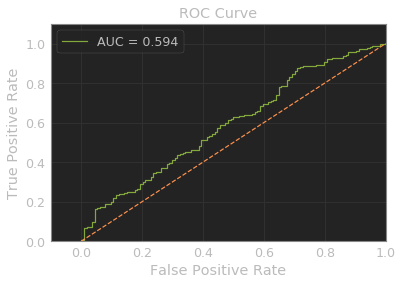

In [107]:
probas_PHY_PSY, labels_PHY_PSY = kmeans_wrapper(PHY_PSY_SVD)
roc_curve_wrapper(y_data, probas_PHY_PSY)

Les résultats ne se sont pas améliorés. Il semble que l'agglomération est meilleure en gardant l'information sur tous les cours qu'en ne gardant que l'information spécfique aux cours PHY et PSY.

Calculs de la précision et du score F1 pour les deux approches:

In [60]:
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score

print("precision for all data: " + str(precision_score(y_data, labels)))
print("F1 score for all data: " + str(f1_score(y_data, labels)))
print("precision for only PHY and PSY courses: " + str(precision_score(y_data, labels_PHY_PSY)))
print("F1 score for only PHY and PSY courses: " + str(f1_score(y_data, labels_PHY_PSY)))

precision for all data: 0.770042194092827
F1 score for all data: 0.8286038592508512
precision for only PHY and PSY courses: 0.7714884696016772
F1 score for only PHY and PSY courses: 0.832579185520362


## 4. À partir de la validation croisée de la tâche de classification ci-dessus, déterminez le nombre de dimensions latentes optimal de SVD selon une approche dite wrapper (4 pts.).

Nous allons maintenant essayer d'améliorer les résultats en utilisant une réduction de dimension. Pour commencer, effectuez une réduction de dimensions à 50 facteurs latents et faites l'agglomération sur la matrice ainsi réduite. Puis refaites les calculs de la question 3. Et finalement, itérez sur différentes nombres de facteurs latents pour identifier la valeur optimale. Elle devrait se situer aux alentours de 20 et donner un AUC nettement supérieur à celui de la question 3.


In [120]:
def kmeans_AUC_for_n_dimensions(n_dimensions=50, use_all_data=True):
    svd = TruncatedSVD(n_components=n_dimensions, 
                   algorithm='randomized', 
                   n_iter=50
                  )
    
    if use_all_data:
        svd.fit(IDF_data)
        svd_matrix_all = svd.transform(IDF_data)
        svd_matrix = retrieve_PHY_PSY(svd_matrix_all)
    else:
        svd.fit(PHY_PSY_TFIDF)
        svd_matrix = svd.transform(PHY_PSY_TFIDF)
    
    predictions, _ = kmeans_wrapper(svd_matrix)
    false_positive_rate, true_positive_rate, threshold = roc_curve(y_data, predictions)
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    if roc_auc < 0.5:
        predictions = reverse_predictions(predictions)
        false_positive_rate, true_positive_rate, threshold = roc_curve(y_data, predictions)
        roc_auc = auc(false_positive_rate, true_positive_rate)
        
    return roc_auc
    

In [109]:
# test 
kmeans_AUC_for_n_dimensions()

0.6251562567352041

In [110]:
aucs_all = []
dims_all = []
for n_dim in range(5, 200, 5):
    aucs_all.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim))
    dims_all.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

In [111]:
def plot_AUC_dim(auc_list, dims_list):
    plt.plot(dims_list, auc_list, 'g')
    plt.legend()
    plt.ylabel('AUC')
    plt.xlabel('Nombre de dimensions')
    plt.title('AUC selon le nombre de dimensions')
    plt.show()

No handles with labels found to put in legend.


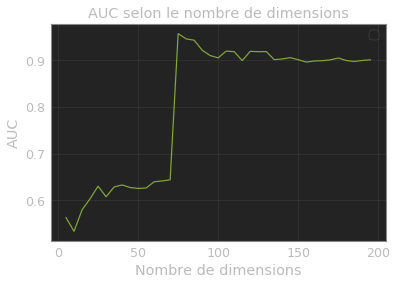

In [112]:
plot_AUC_dim(aucs_all, dims_all)

Nous allons refaire l'expérience mais uniquement avec les données des cours PHY et PSY

In [121]:
aucs = []
dims = []
for n_dim in range(5, 200, 5):
    aucs.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim, use_all_data=False))
    dims.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

No handles with labels found to put in legend.


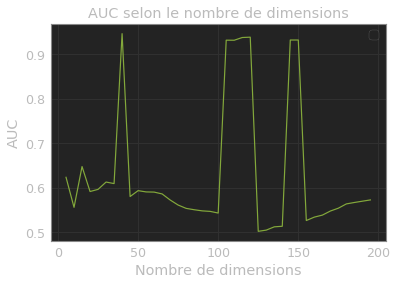

In [122]:
plot_AUC_dim(aucs, dims)

In [123]:
aucs = []
dims = []
for n_dim in range(30, 50):
    aucs.append(kmeans_AUC_for_n_dimensions(n_dimensions=n_dim, use_all_data=False))
    dims.append(n_dim)
    print("dimensions: " + str(n_dim), end='\r')

No handles with labels found to put in legend.


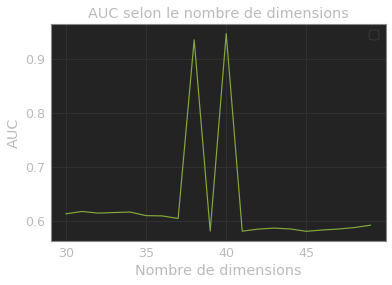

In [124]:
plot_AUC_dim(aucs, dims)